In [322]:
import numpy as np
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [323]:
N=10
dn=10 ** (-20)
M=100
dm=10 ** (-12)
NT = 6

In [324]:
eps1 = 1 * np.ones((NT - 1, M))
sigma1 = 0 * np.ones((NT - 1, M))
diff1 = 0 * np.ones((NT - 1, M))

eps2 = 1 * np.ones((N - NT + 1, M))
sigma2 = 10 ** (-3) * np.ones((N - NT + 1, M))
diff2 = 10 ** (-9) * np.ones((N - NT + 1, M))

eps_all = np.concatenate([eps1, eps2])
sigma_all = np.concatenate([sigma1, sigma2])
diff_all = np.concatenate([diff1, diff2])

eps0 = 8.85 * 10 ** (-12)
div_eps0 = 1 / eps0


In [325]:
#TODO dn в производных
def get_system_matrix_internal():
    equa_num = (NT - 3) * (M - 2)
    row = np.arange(equa_num)
    col = np.array([[n * M + m for m in range(1, M - 1)] for n in range(1, NT - 2)]).reshape(equa_num)
    data1 = np.ones(equa_num)
    data2 = (div_eps0 / eps1[1:-1, 1: - 1]).reshape(equa_num)

    poison_air_matrix = (
            sp.coo_matrix((-4 * data1, (row, col)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col + 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col - 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col + M)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col - M)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data2, (row, col + M * N)), shape=(equa_num, 2 * N * M))
    )

    germgolc_air_matrix = sp.coo_matrix((data1, (row, col + M * N)), shape=(equa_num, 2 * N * M))

    # plt.matshow(poison_air_matrix.toarray()[:,:N*M])
    # plt.matshow(poison_air_matrix.toarray()[:,N*M:])
    # plt.matshow(germgolc_air_matrix.toarray()[:,:N*M])
    # plt.matshow(germgolc_air_matrix.toarray()[:,N*M:])
    equa_num = (N - NT - 1) * (M - 2)
    row = np.arange(equa_num)
    col = np.array([[n * M + m for m in range(1, M - 1)] for n in range(NT, N - 1)]).reshape(equa_num)
    data1 = np.ones(equa_num)
    data2 = (div_eps0 / eps2[1:-1, 1:-1]).reshape(equa_num)

    poison_tissue_matrix = (
            sp.coo_matrix((-4 * data1, (row, col)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col + 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col - 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col + M)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1, (row, col - M)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data2, (row, col + M * N)), shape=(equa_num, 2 * N * M))
    )

    data1 = np.array(
        [0.25 * (diff2[1:-1, 2:] + diff2[1:-1, :-2] +
                 diff2[2:, 1:-1] + diff2[:-2, 1:-1]).reshape(equa_num),
         0.5 * (diff2[1:-1, 1:-1] + diff2[:-2, 1:-1]).reshape(equa_num),
         0.5 * (diff2[1:-1, 1:-1] + diff2[2:, 1:-1]).reshape(equa_num),
         0.5 * (diff2[1:-1, 1:-1] + diff2[1:-1, :-2]).reshape(equa_num),
         0.5 * (diff2[1:-1, 1:-1] + diff2[1:-1, 2:]).reshape(equa_num)]
    )
    data2 = div_eps0 * (sigma2[1:-1, 1:-1] / eps2[1:-1, 1:-1]).reshape(equa_num)
    germgolc_tissue_matrix = (
            sp.coo_matrix((-4 * data1[0] - data2, (row, col)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1[4], (row, col + 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1[3], (row, col - 1)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1[2], (row, col + M)), shape=(equa_num, 2 * N * M)) +
            sp.coo_matrix((data1[1], (row, col - M)), shape=(equa_num, 2 * N * M))
    )
    # plt.matshow(poison_tissue_matrix.toarray()[:,:N*M])
    # plt.matshow(poison_tissue_matrix.toarray()[:,N*M:])
    # plt.matshow(germgolc_tissue_matrix.toarray()[:,:N*M])
    # plt.matshow(germgolc_tissue_matrix.toarray()[:,N*M:])
    return sp.vstack([poison_air_matrix, germgolc_air_matrix, poison_tissue_matrix, germgolc_tissue_matrix])


In [326]:
def Dirichlet(variable_name, coordinates, value):
    equa_num = len(coordinates)
    row = np.arange(equa_num)
    col = np.array([coo[0] * M + coo[1] for coo in coordinates])
    data = np.ones(equa_num)

    vector = value
    if variable_name == 'u':
        matrix = sp.coo_matrix((data, (row, col)), shape=(equa_num, 2 * N * M))
    elif variable_name == 'v':
        matrix = sp.coo_matrix((data, (row, col + N * M)), shape=(equa_num, 2 * N * M))

    return matrix, vector

def Newmann(variable_name, coordinates, external_normal, value):
    equa_num = len(coordinates)
    row = np.arange(equa_num)
    col = np.array([coo[0] * M + coo[1] for coo in coordinates])
    data = np.ones(equa_num)

    normal = external_normal
    vector = value * (normal[0] * dn + normal[1] * dm)
    if variable_name == 'u':
        matrix = (sp.coo_matrix((data * (normal[0] + normal[1]), (row, col)),
                                shape=(equa_num, 2 * N * M)) +
                  sp.coo_matrix((-data * (normal[0] + normal[1]), (row, col - normal[0] * M - normal[1])),
                                shape=(equa_num, 2 * N * M)))
    elif variable_name == 'v':
        matrix = (sp.coo_matrix((data * (normal[0] + normal[1]), (row, col + N * M)),
                                shape=(equa_num, 2 * N * M)) +
                  sp.coo_matrix((-data * (normal[0] + normal[1]), (row, col - normal[0] * M - normal[1] + N * M)),
                                shape=(equa_num, 2 * N * M)))
    elif variable_name == 'j':
        data_sigma = sigma_all[coordinates[:, 0], coordinates[:, 1]]
        data_diff = diff_all[coordinates[:, 0], coordinates[:, 1]]
        matrix = (sp.coo_matrix((data_sigma * (normal[0] + normal[1]), (row, col)),
                                shape=(equa_num, 2 * N * M)) +
                  sp.coo_matrix((-data_sigma * (normal[0] + normal[1]), (row, col - normal[0] * M - normal[1])),
                                shape=(equa_num, 2 * N * M)) +
                  sp.coo_matrix((data_diff * (normal[0] + normal[1]), (row, col + N * M)),
                                shape=(equa_num, 2 * N * M)) +
                  sp.coo_matrix((-data_diff * (normal[0] + normal[1]), (row, col - normal[0] * M - normal[1] + N * M)),
                                shape=(equa_num, 2 * N * M)))

    return matrix, vector

def Continiosly(variable_name, coordinates_in, coordinates_out, ratio, ratio_dif):
    equa_num = len(coordinates_in)
    row = np.arange(equa_num)
    col1 = np.array([coo[0] * M + coo[1] for coo in coordinates_in])
    col2 = np.array([coo[0] * M + coo[1] for coo in coordinates_out])

    data = np.ones(equa_num)
    vector = np.zeros(2 * equa_num)

    if variable_name == 'u':
        matrix = sp.vstack([
            (sp.coo_matrix((data, (row, col1)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-ratio, (row, col2)), shape=(equa_num, 2 * N * M))),
            (sp.coo_matrix((data, (row, col1)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-data, (row, col1 - M)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((ratio_dif, (row, col2)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-ratio_dif, (row, col2 + M)), shape=(equa_num, 2 * N * M)))
        ])

    elif variable_name == 'v':
        matrix = sp.vstack([
            (sp.coo_matrix((data, (row, col1 + N * M)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-ratio, (row, col2 + N * M)), shape=(equa_num, 2 * N * M))),
            (sp.coo_matrix((data, (row, col1 + N * M)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-data, (row, col1 - M + N * M)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((ratio_dif, (row, col2 + N * M)), shape=(equa_num, 2 * N * M)) +
             sp.coo_matrix((-ratio_dif, (row, col2 + M + N * M)), shape=(equa_num, 2 * N * M)))
        ])

    return matrix, vector
# coo = np.array([[0, m] for m in range(M)])
# plt.matshow(Dirichlet('v', coo, np.ones(len(coo)))[0].toarray())
# plt.matshow(Newmann('u', coo, [-1, 0], np.ones(len(coo)))[0].toarray())
# coo = np.array([[N - 1, m] for m in range(M)])
# plt.matshow(Newmann('u', coo, [1, 0], np.ones(len(coo)))[0].toarray())
# plt.matshow(Newmann('j', coo, [1, 0], np.ones(len(coo)))[0].toarray()[:, :N * M])
# plt.matshow(Newmann('j', coo, [1, 0], np.ones(len(coo)))[0].toarray()[:, N * M:])
# plt.matshow(
#     Continiosly('v', np.array([[NT - 1, m] for m in range(M)]), np.array([[NT, m] for m in range(M)]),
#                 np.ones(M), 2 * np.ones(M))[0].toarray())

In [327]:
def solver2D(boundary_conditions):
    system_matrix = get_system_matrix_internal()
    free_vector = np.zeros(system_matrix.shape[0])
    for matrix,vector in boundary_conditions:
        system_matrix = sp.vstack([system_matrix,matrix])
        free_vector = np.concatenate([free_vector,vector])
        
    uv = spsolve(system_matrix.tocsr(), free_vector).reshape(2, N, M)
    return uv[0], uv[1]

In [328]:
coo_air_n_start = np.array([[0, m] for m in range(M)])
coo_air_n_stop = np.array([[NT - 2, m] for m in range(M)])
coo_air_m_start = np.array([[n, 0] for n in range(0, NT - 1)])
coo_air_m_stop = np.array([[n, M - 1] for n in range(0, NT - 1)])

coo_tissue_n_start = np.array([[NT-1, m] for m in range(M)])
coo_tissue_n_stop = np.array([[N-1, m] for m in range(M)])
coo_tissue_m_start = np.array([[n, 0] for n in range(NT-1, N)])
coo_tissue_m_stop = np.array([[n, M - 1] for n in range(NT-1, N)])

boundary_conditions = [
    Dirichlet('u',coo_air_n_start,np.zeros(M)),
    Dirichlet('u',coo_air_m_start[1:-1],np.zeros(NT-3)),
    Dirichlet('u',coo_air_m_stop[1:-1],np.zeros(NT-3)),
    
    Dirichlet('v',coo_air_n_start,np.zeros(M)),
    Dirichlet('v',coo_air_m_start[1:-1],np.zeros(NT-3)),
    Dirichlet('v',coo_air_m_stop[1:-1],np.zeros(NT-3)),
    
    Newmann('u',coo_tissue_n_stop,[1,0],np.zeros(M)),
    Dirichlet('u',coo_tissue_m_start[1:-1],np.ones(N-NT-1)),
    Dirichlet('u',coo_tissue_m_stop[1:-1],-np.ones(N-NT-1)),
    
    Newmann('j',coo_tissue_n_stop,[1,0],np.zeros(M)),
    Newmann('j',coo_tissue_m_start[1:-1],[0,-1],np.zeros(N-NT-1)),
    Newmann('j',coo_tissue_m_stop[1:-1],[0,1],np.zeros(N-NT-1)),
    
    Continiosly('u',coo_air_n_stop,coo_tissue_n_start,np.ones(M),eps2[0]/eps1[-1]),
    Dirichlet('v',coo_air_n_stop,np.zeros(M)),
    Newmann('j',coo_tissue_n_start,[-1,0],np.zeros(M))
]
u,v = solver2D(boundary_conditions)


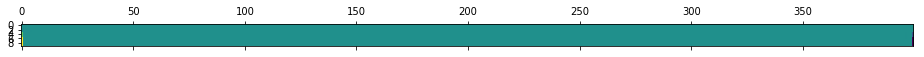

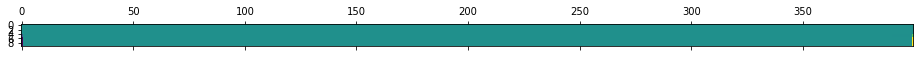

In [330]:
plt.matshow(u)
plt.matshow(v)

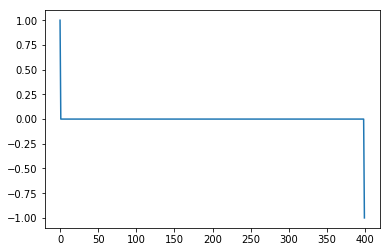

In [332]:
plt.plot(u[-1])